In [1]:
'''
as part of MS4 green infrastructure equity work and following this guidance from MA: 
https://www.mass.gov/doc/2016-massachusetts-small-ms4-permit-pollutant-loading-export-rates/download

generating PLER values for each land cover area in each municipality

created: 5/2/2023
author: rbowers

'''

import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import sys
sys.path.append("..")
import statsmodels.api as sm
from statsmodels.formula.api import ols 
from rasterstats import zonal_stats
import contextily as cx
#import osmnx as ox
from affine import Affine
import rioxarray as rx
from multiprocessing import Pool, cpu_count
from shapely.ops import unary_union
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
from pathlib import Path
import geopandas as gpd

import matplotlib.pyplot as plt
import rasterio
from rasterio import features
from rasterio.enums import MergeAlg
from rasterio.plot import show
from numpy import int16


#see all columns in tables
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

In [ ]:
#land use geodatabase location
lclu_gdb = "K:\\DataServices\\Datasets\\Zoning and Land Use\\Spatial\\lclu_gdb\\MA_LCLU2016.gdb"
lclu = gpd.read_file(lclu_gdb, layer="LANDCOVER_LANDUSE_POLY")

In [37]:
muni = 'Natick'

print('Starting on municipality: ', muni)

#read in municipalities, select the one of interest
#municipalities
munis_fp = "K:\\\DataServices\\Datasets\\Boundaries\\Spatial\\mapc_towns_poly.shp"
munis = gpd.read_file(munis_fp)

#select just the muni 
muni_shp = munis.loc[munis['municipal'] == muni]

print('Reading in Land Cover/Land Use Data...')



print('Reading in Soils Data...')

#soils geodabatse location
ms4_gdb = 'K:\\DataServices\\Projects\\Current_Projects\\Environment\\MS4\\Project\\MS4_Tool_Preprocessing.gdb'
soils_hsg = gpd.read_file(ms4_gdb, layer="SOILS_MUPOLYGON_TOP20_MAPCclip", mask=muni_shp)

print('Reading in urban heat island Data...')
#bring in heat island raster so that we can build our dataset off of it 
heat_fp = 'K:\\DataServices\\Projects\\Current_Projects\\Climate_Change\\MVP_MMC_Heat_MVP\\00 Task 2 Deliverables\\2.1 Attachments\\00 Uploaded to Sharepoint\\Shapefile_LSTIndex\\LSTindex.tif'
heat = rasterio.open(heat_fp)
#mask by muni

'''
with rasterio.open(heat_fp) as heat:
    out_image, out_transform = rasterio.mask.mask(heat, muni_shp.geometry, crop=True)
    out_meta = src.meta
'''
masked_raster, masked_raster_transform = rasterio.mask.mask(heat, muni_shp[['geometry']].values.flatten())



#reproject all to mass mainland
mass_mainland_crs = "EPSG:26986"
lclu = lclu.to_crs(mass_mainland_crs)
muni_shp = muni_shp.to_crs(mass_mainland_crs)
soils_hsg = soils_hsg.to_crs(mass_mainland_crs)


Starting on municipality:  Natick
Reading in Land Cover/Land Use Data...
Reading in Soils Data...
Reading in urban heat island Data...


In [67]:
from src.features.build_features import *
heat_muni =  mask_raster(mask_df=muni_shp, 
                        raster_fp=heat_fp)

AttributeError: 'dict' object has no attribute 'encode'

TypeError: Image data of dtype object cannot be converted to float

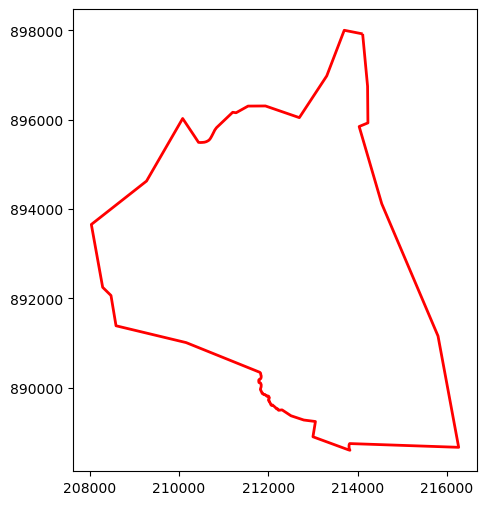

In [60]:
fig, ax = plt.subplots(figsize=(8, 6))
p1 = muni_shp.plot(color=None,facecolor='none',edgecolor='red',linewidth = 2,ax=ax)
show(heat_muni, ax=ax)
ax.axis('off')

In [43]:
#rasterize land cover
from rasterio import features
from rasterio import transform

#vectorize rasters
polys_to_rasterize = [lclu, soils_hsg]

#create tuples of geometry, value pairs, where value is the attribute value you want to burn
vector = lclu
value_field = 'COVERCODE'
geom_value = ((geom,value) for geom, value in zip(vector.geometry, vector[value_field]))
raster = heat_muni

                                
# Rasterize vector using the shape and transform of the raster
rasterized_lclu = features.rasterize(geom_value,
                                out_shape = raster.shape,
                                transform = raster.transform,
                                all_touched = True,
                                fill = -5,   # background value
                                merge_alg = MergeAlg.replace,
                                dtype = int16)


AttributeError: 'numpy.ndarray' object has no attribute 'transform'

<AxesSubplot:>

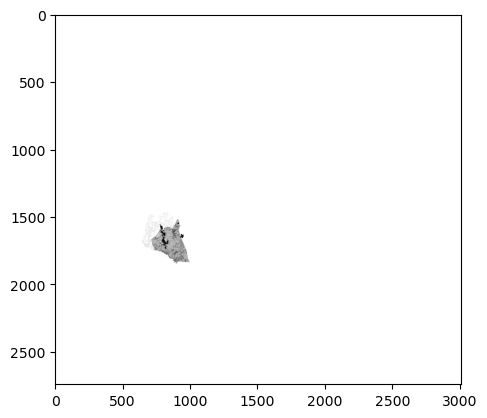

In [35]:
# Plot the Polygon on top of the raster
ax = muni_shp.plot(facecolor='None', edgecolor='black', linewidth=.5)

# Plot tmp
show(rasterized, ax=ax, cmap='Greys')


<AxesSubplot:>

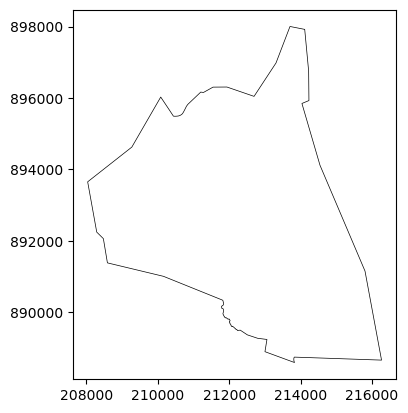

In [32]:
muni_shp.plot(facecolor='None', edgecolor='black', linewidth=.5)

In [20]:
#add overlap with soil hydrologic group (HYDROLGRP) 
from src.features.build_features import *
lclu_with_soils = overlap_sjoin(target_layer=lclu, 
                                overlap_layer=soils_hsg, 
                                field='HYDROLGRP', 
                                stats='first')

lclu_with_soils.head()

error here


,COVERNAME,COVERCODE,USEGENNAME,USEGENCODE,USE_CODE,POLY_TYPE,FY,TOWN_ID,TILENAME,Shape_Length_left,Shape_Area_left,geometry,HYDROLGRP_first
0,Deciduous Forest,9,Residential - single family,11,101,FEE,2011,198,R08C17,85.497475,306.500000,"MULTIPOLYGON (((213945.267 897369.572, 213946....",A
1,Deciduous Forest,9,Tax exempt,9,924,FEE,2011,198,R08C17,54.009296,56.815985,"MULTIPOLYGON (((213830.970 897369.885, 213830....",A
2,Evergreen Forest,10,Right-of-way,55,000,ROW,2011,198,R08C17,64.219558,88.685490,"MULTIPOLYGON (((213821.037 897364.066, 213799....",A
3,Evergreen Forest,10,Tax exempt,9,924,FEE,2011,198,R08C17,41.723008,81.968114,"MULTIPOLYGON (((213831.782 897373.392, 213831....",A
4,Evergreen Forest,10,Unknown,0,000,NaN,0,0,R08C17,51.065457,3.890252,"MULTIPOLYGON (((213462.551 897379.408, 213454....",A


In [22]:
#calculate area in acreage
lclu_with_soils['acres'] = lclu_with_soils.area / 43560


#distinguish between impervious and pervious
impervious = lclu_with_soils.loc[lclu_with_soils['COVERNAME'] == 'Impervious']
pervious = lclu_with_soils.loc[lclu_with_soils['COVERNAME'] != 'Impervious']

In [23]:
use_1_vals = ['Mixed use, primarily residential', 'Residential - multi-family']
use_2_vals = ['Commercial', 'Industrial', 'Tax exempt', 'Mixed use, other', 'Mixed use, primarily commercial'] 
use_3_vals = ['Right-of-way']
use_4_vals = ['Forest']
use_5_vals = ['Agriculture']
use_6_vals = ['Unknown', 'Open land', 'Recreation']
use_7_vals = ['Residential - other', 'Residential - single family']

cover_1_vals = ['Deciduous Forest', 'Evergreen Forest', 'Scrub/Shrub']
cover_2_vals = ['Developed Open Space', 'Grassland', 'Palustrine Forested Wetland', 
                'Palustrine Scrub/Shrub Wetland', 'Palustrine Emergent Wetland',
                'Estuarine Forested Wetland', 'Estuarine Scrub/Shrub Wetland', 'Estuarine Emergent Wetland'
                ]
cover_3_vals = ['Cultivated', 'Pasture/Hay']
cover_4_vals = ['Developed Open Space', 'Grassland', 'Palustrine Forested Wetland', 'Palustrine Scrub/Shrub Wetland',
                'Palustrine Emergent Wetland', 'Estuarine Emergent Wetland', 'Estuarine Forested Wetland', 'Estuarine Scrub/Shrub Wetland',
                'Unconsolidated Shore', 'Bare Land']

PLER_rule = [
    (lclu_with_soils['COVERNAME'] == 'Impervious') & lclu_with_soils['USEGENNAME'].isin(use_1_vals),
    (lclu_with_soils['COVERNAME'] == 'Impervious') & lclu_with_soils['USEGENNAME'].isin(use_2_vals),
    (lclu_with_soils['COVERNAME'] == 'Impervious') & lclu_with_soils['USEGENNAME'].isin(use_3_vals),
    (lclu_with_soils['COVERNAME'] == 'Impervious') & lclu_with_soils['USEGENNAME'].isin(use_4_vals),
    (lclu_with_soils['COVERNAME'] == 'Impervious') & lclu_with_soils['USEGENNAME'].isin(use_5_vals),
    (lclu_with_soils['COVERNAME'] == 'Impervious') & lclu_with_soils['USEGENNAME'].isin(use_6_vals),
    (lclu_with_soils['COVERNAME'] == 'Impervious') & lclu_with_soils['USEGENNAME'].isin(use_7_vals),
    (lclu_with_soils['COVERNAME'] != 'Impervious') &  lclu_with_soils['COVERNAME'].isin(cover_1_vals),
    (lclu_with_soils['COVERNAME'] != 'Impervious') & (lclu_with_soils['USEGENNAME'] == 'Forest') & lclu_with_soils['COVERNAME'].isin(cover_2_vals),
    (lclu_with_soils['COVERNAME'] != 'Impervious') &  lclu_with_soils['COVERNAME'].isin(cover_3_vals),
    (lclu_with_soils['COVERNAME'] != 'Impervious') & (lclu_with_soils['COVERNAME'] == 'Developed Open Space') & (lclu_with_soils['USEGENNAME']== 'Agriculture'),
    (lclu_with_soils['COVERNAME'] != 'Impervious') & (lclu_with_soils['COVERNAME'] == 'Grassland') & (lclu_with_soils['USEGENNAME']== 'Agriculture'),
    (lclu_with_soils['COVERNAME'] != 'Impervious') & (lclu_with_soils['COVERNAME'] == 'Pasture/Hay') & (lclu_with_soils['USEGENNAME']== 'Forest')
]

choices = [2.32, 1.78, 1.95, 1.52, 1.52, 1.52, 1.96, 0.13, 0.13, 0.45, 0.45, 0.45, 0.45]

lclu_with_soils['PLER'] = np.select(PLER_rule, choices, default=np.nan)
lclu_with_soils[['COVERNAME', 'USEGENNAME', 'PLER', 'acres']]



,COVERNAME,USEGENNAME,PLER,acres
0,Deciduous Forest,Residential - single family,0.13,7.035807e-03
1,Deciduous Forest,Tax exempt,0.13,1.304229e-03
2,Evergreen Forest,Right-of-way,0.13,2.035803e-03
3,Evergreen Forest,Tax exempt,0.13,1.881605e-03
4,Evergreen Forest,Unknown,0.13,8.930212e-05
...,...,...,...,...
92639,Developed Open Space,Residential - single family,NaN,1.619255e-02
92640,Palustrine Forested Wetland,Residential - single family,NaN,1.361576e-03
92641,Impervious,Residential - single family,1.96,2.352911e-03
92642,Deciduous Forest,Right-of-way,0.13,1.937693e-03


In [24]:
lclu_with_soils.head()

,COVERNAME,COVERCODE,USEGENNAME,USEGENCODE,USE_CODE,POLY_TYPE,FY,TOWN_ID,TILENAME,Shape_Length_left,Shape_Area_left,geometry,HYDROLGRP_first,acres,PLER
0,Deciduous Forest,9,Residential - single family,11,101,FEE,2011,198,R08C17,85.497475,306.500000,"MULTIPOLYGON (((213945.267 897369.572, 213946....",A,0.007036,0.13
1,Deciduous Forest,9,Tax exempt,9,924,FEE,2011,198,R08C17,54.009296,56.815985,"MULTIPOLYGON (((213830.970 897369.885, 213830....",A,0.001304,0.13
2,Evergreen Forest,10,Right-of-way,55,000,ROW,2011,198,R08C17,64.219558,88.685490,"MULTIPOLYGON (((213821.037 897364.066, 213799....",A,0.002036,0.13
3,Evergreen Forest,10,Tax exempt,9,924,FEE,2011,198,R08C17,41.723008,81.968114,"MULTIPOLYGON (((213831.782 897373.392, 213831....",A,0.001882,0.13
4,Evergreen Forest,10,Unknown,0,000,NaN,0,0,R08C17,51.065457,3.890252,"MULTIPOLYGON (((213462.551 897379.408, 213454....",A,0.000089,0.13


In [ ]:
cover_4_vals = ['Developed Open Space', 'Grassland', 'Palustrine Forested Wetland', 'Palustrine Scrub/Shrub Wetland',
                'Palustrine Emergent Wetland', 'Estuarine Emergent Wetland', 'Estuarine Forested Wetland', 'Estuarine Scrub/Shrub Wetland',
                'Unconsolidated Shore', 'Bare Land']

#next add an hsg and 

In [ ]:
['Deciduous Forest' 'Evergreen Forest' 'Developed Open Space'
 'Palustrine Scrub/Shrub Wetland' 'Impervious'
 'Palustrine Forested Wetland' 'Palustrine Emergent Wetland' 'Grassland'
 'Bare Land' 'Scrub/Shrub' 'Water' 'Palustrine Aquatic Bed' 'Pasture/Hay'
 'Cultivated']

['Residential - single family' 'Tax exempt' 'Right-of-way' 'Unknown'
 'Open land' 'Water' 'Residential - multi-family' 'Industrial'
 'Commercial' 'Recreation' 'Agriculture' 'Residential - other' 'Forest'
 'Mixed use, other' 'Mixed use, primarily residential']